In [3]:
import pandas as pd
import re
import string
import numpy as np
import sentencepiece as spm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from typing import List


In [48]:
MAX_SEQUENCE_LENGTH = 70  # Max length of input sequences
EMBEDDING_DIM = 128        # Word embedding dimension
LSTM_UNITS = 128           # LSTM units
BATCH_SIZE = 32
EPOCHS = 10

In [49]:
def remove_single_characters(tokens: List[str]) -> List[str]:
    """Removes single-character tokens."""
    return [token for token in tokens if len(token) > 1]

In [50]:
def clean_text(text: str) -> str:
    """Cleans text by removing unwanted symbols, URLs, HTML, and numbers."""
    text = re.sub(r'\[.*?\]', '', text)  # Remove text inside brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

In [51]:
def lower_case_everything(t: str) -> str:
    return t.lower()

def replace_all_caps(tokens: List[str]) -> List[str]:
    return [f'xxup {t.lower()}' if t.isupper() else t for t in tokens]

def deal_caps(tokens: List[str]) -> List[str]:
    return [f'xxmaj {t}' if t.istitle() else t for t in tokens]

def handle_all_caps(t: str) -> str:
    tokens = t.split()
    tokens = replace_all_caps(tokens)
    return ' '.join(tokens)

def handle_upper_case_first_letter(t: str) -> str:
    tokens = t.split()
    tokens = deal_caps(tokens)
    return ' '.join(tokens)

In [52]:
custom_pre_rules = [lower_case_everything, handle_all_caps, handle_upper_case_first_letter]

In [53]:
def preprocess_text(text: str) -> str:
    """Applies all preprocessing rules."""
    text = clean_text(str(text))
    for rule in custom_pre_rules:
        text = rule(text)
    return text

In [54]:
class CodeMixedTanglishTokenizer:
    def __init__(self, model_path: str):
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path)

    def __call__(self, items: List[str]) -> List[List[str]]:  
        return [self.sp.EncodeAsPieces(t) for t in items]

    def tokenizer(self, items: List[str]) -> List[List[str]]:
        return [self.sp.EncodeAsPieces(t) for t in items]

In [55]:
tokenizer = CodeMixedTanglishTokenizer("../Tokenizer/Tanglish/taen_spm.model")

In [56]:
tokenizer.sp.EncodeAsPieces("otha ootha")


['▁otha', '▁ootha']

In [57]:
df = pd.read_csv("../Dataset/Main/main_dataset.csv")

In [58]:
y = np.array(df['category'])
s = set(y)
s

{'NOT', 'OFF', 'OFf', 'label', 'not'}

In [59]:
print("Before: ",len(df))
unwanted_labels = {'OFf','label','not'}
df = df[~df['category'].isin(unwanted_labels)]
print("After: ",len(df))

Before:  13255
After:  13252


In [60]:
label_mapping = {
    "NOT" : 0,
    "OFF" : 1
}

In [61]:
df.head()

,text,category
0,# # # # # # # # Yesus Kristus adalah...,NOT
1,# 1 TRENDING.... NEVER EVER GIVE UP....,NOT
2,# I set your screens on # Vaa thalaiva#,NOT
3,#1 Trending in Singapore #9 Australia.,NOT
4,"#aarambam --ajith, arya compo🤩 #Kaappan ---s...",NOT


In [62]:
df["category"] = df["category"].map(label_mapping)
df.head()

,text,category
0,# # # # # # # # Yesus Kristus adalah...,0
1,# 1 TRENDING.... NEVER EVER GIVE UP....,0
2,# I set your screens on # Vaa thalaiva#,0
3,#1 Trending in Singapore #9 Australia.,0
4,"#aarambam --ajith, arya compo🤩 #Kaappan ---s...",0


In [63]:
df["text"] = df["text"].apply(preprocess_text)
df.head()

,text,category
0,yesus kristus adalah anak allah yang mati dan ...,0
1,trending never ever give up,0
2,i set your screens on vaa thalaiva,0
3,trending in singapore australia,0
4,aarambam ajith arya compo🤩 kaappan surya arya ...,0


In [64]:
df["tokens"] = tokenizer.tokenizer(df["text"].tolist())
df[78:85]

,text,category,tokens
78,user varushama oombinu irukan thayoli sotta ko...,1,"[▁user, ▁varushama, ▁oombi, nu, ▁irukan, ▁thay..."
79,user hit neegro koothi vijuvoli,1,"[▁user, ▁hit, ▁nee, gro, ▁koothi, ▁viju, voli]"
80,user years old at the last year oru clean hit ...,1,"[▁user, ▁years, ▁old, ▁at, ▁the, ▁last, ▁year,..."
81,user million subscribers irukura app da kavin ...,1,"[▁user, ▁million, ▁subscribers, ▁irukura, ▁app..."
82,user pera follow pannuvan but id ya tag pannuv...,0,"[▁user, ▁pera, ▁follow, ▁pannuvan, ▁but, ▁id, ..."
83,user day post semaya podunga vaalthukkalore ma...,0,"[▁user, ▁day, ▁post, ▁semaya, ▁podunga, ▁vaalt..."
84,user la out of persons chennai illa remaining ...,0,"[▁user, ▁la, ▁out, ▁of, ▁persons, ▁chennai, ▁i..."


In [65]:
df["encoded"] = df["tokens"].apply(lambda tokens: [tokenizer.sp.PieceToId(piece) for piece in tokens])

In [66]:
max_token_id = max([max(seq) for seq in df["encoded"] if len(seq) > 0])
print("Maximum Token Index in Dataset:", max_token_id)

Maximum Token Index in Dataset: 170250


In [67]:
X_padded = pad_sequences(df["encoded"].tolist(), maxlen=MAX_SEQUENCE_LENGTH, padding="post")

In [68]:
df.head()

,text,category,tokens,encoded
0,yesus kristus adalah anak allah yang mati dan ...,0,"[▁yesu, s, ▁krist, us, ▁adalah, ▁anak, ▁allah,...","[18698, 17, 28189, 955, 42607, 21681, 9941, 16..."
1,trending never ever give up,0,"[▁trending, ▁never, ▁ever, ▁give, ▁up]","[680, 2793, 1597, 2815, 696]"
2,i set your screens on vaa thalaiva,0,"[▁i, ▁set, ▁your, ▁screens, ▁on, ▁vaa, ▁thalaiva]","[129, 1044, 1081, 12845, 393, 398, 325]"
3,trending in singapore australia,0,"[▁trending, ▁in, ▁singapore, ▁australia]","[680, 137, 31714, 29049]"
4,aarambam ajith arya compo🤩 kaappan surya arya ...,0,"[▁aarambam, ▁ajith, ▁arya, ▁compo, 🤩, ▁kaappan...","[8304, 322, 6738, 20733, 3128, 5505, 239, 6738..."


In [69]:
X_padded = pad_sequences(df["encoded"].tolist(), maxlen=MAX_SEQUENCE_LENGTH, padding="post")
y = df["category"].values


In [70]:
print(X_padded)
print(y)

print(len(X_padded[0]))

[[18698    17 28189 ...     0     0     0]
 [  680  2793  1597 ...     0     0     0]
 [  129  1044  1081 ...     0     0     0]
 ...
 [19895  1226   290 ...     0     0     0]
 [ 3215 19895 29648 ...     0     0     0]
 [ 3215 19895   707 ...     0     0     0]]
[0 0 0 ... 1 1 1]
70


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.3, random_state=42, stratify=y)

In [72]:
model = Sequential([
    Embedding(input_dim=max_token_id+1, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),  # BiLSTM Layer
    Bidirectional(LSTM(LSTM_UNITS)),  # Another BiLSTM
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(len(label_mapping), activation="softmax")  # Multi-class classification
])

d:\FYP2\Audio_model\venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [73]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

In [74]:
model.fit(X_train, np.array(y_train), batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_test, np.array(y_test)))

Epoch 1/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 100s 314ms/step - accuracy: 0.7628 - loss: 0.4586 - val_accuracy: 0.9374 - val_loss: 0.1652
Epoch 2/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 90s 310ms/step - accuracy: 0.9822 - loss: 0.0605 - val_accuracy: 0.9482 - val_loss: 0.1431
Epoch 3/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 93s 319ms/step - accuracy: 0.9932 - loss: 0.0285 - val_accuracy: 0.9515 - val_loss: 0.1494
Epoch 4/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 92s 318ms/step - accuracy: 0.9947 - loss: 0.0194 - val_accuracy: 0.9552 - val_loss: 0.1736
Epoch 5/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 93s 320ms/step - accuracy: 0.9977 - loss: 0.0099 - val_accuracy: 0.9474 - val_loss: 0.2449
Epoch 6/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 96s 330ms/step - accuracy: 0.9961 - loss: 0.0161 - val_accuracy: 0.9515 - val_loss: 0.2688
Epoch 7/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 94s 324ms/step - accuracy: 0.9966 - loss: 0.0124 - val_accuracy: 0.9479 - val_loss: 0.2767
Epoch 8/10
290/290 ━━━━━━━━━━━━━━━━━━━━ 94s 323ms/step - accuracy: 0.9947 - loss: 

In [75]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step


In [76]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")  # Print accuracy
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9512

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96      2283
           1       0.94      0.95      0.94      1693

    accuracy                           0.95      3976
   macro avg       0.95      0.95      0.95      3976
weighted avg       0.95      0.95      0.95      3976



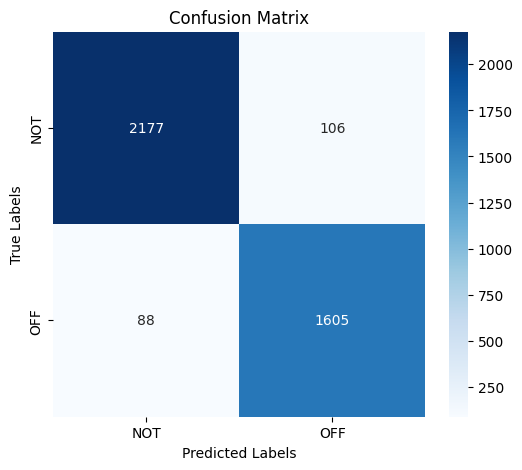

In [111]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

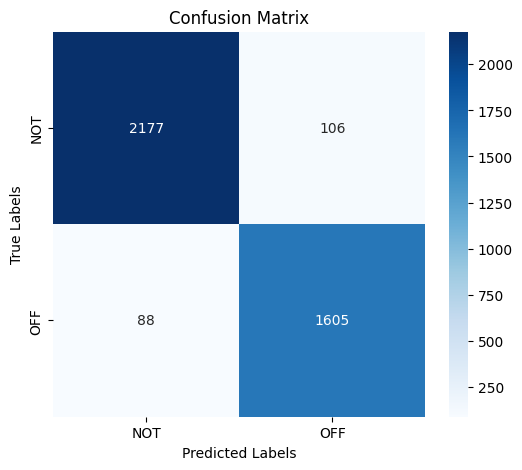

Misclassified samples saved to misclassified_samples.txt


In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Ensure y_test and y_pred are NumPy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Identify misclassified samples
misclassified_indices = np.where(y_test != y_pred)[0]  # Get indices where prediction is incorrect

# Open file to store misclassified texts
with open("misclassified_samples.txt", "w", encoding="utf-8") as file:
    for i in misclassified_indices:
        text = X_test[i]  # Extract misclassified text
        true_label = y_test[i]  # Get true label
        pred_label = y_pred[i]  # Get predicted label
        file.write(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label: {pred_label}\n\n")

print("Misclassified samples saved to misclassified_samples.txt")


In [117]:
test_texts = ["d"]
test_texts_cleaned = [preprocess_text(text) for text in test_texts]
test_texts_tokenized = tokenizer.tokenizer(test_texts_cleaned)
test_texts_encoded = [tokenizer.sp.PieceToId(piece) for text in test_texts_tokenized for piece in text]
test_texts_padded = pad_sequences([test_texts_encoded], maxlen=MAX_SEQUENCE_LENGTH, padding="post")
#print(test_texts_padded)

predictions = model.predict(test_texts_padded)
predicted_labels = np.argmax(predictions, axis=1)

print(predictions)
print(predicted_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
[[0.12659357 0.87340647]]
[1]


In [88]:
model.save("bilstm_model1.h5")

In [18]:
s1 = df[(df["text"].str.contains(r"\bumbu\b", case=False, na=False)) & (df["category"] == "OFF")]["text"]
s1.to_csv("./temp/umbu.txt", index=False, header=False)
print("Saved successfully")

Saved successfully


In [41]:
# Open the original file and read lines
with open("./temp/kuthi.txt", "r", encoding="utf-8") as file:
    lines = file.readlines()

# Open the new file to write modified sentences
with open("./temp/new/kuthi_new.txt", "w", encoding="utf-8") as file:
    for line in lines:
        line = line.strip()  # Remove any extra spaces or newlines
        #file.write(line + "\n")  # Write the original line
        file.write(re.sub(r"\bkuthi\b", "koothi", line, flags=re.IGNORECASE) + "\n")
        #file.write(re.sub(r"\bgommala\b", "ommaala", line, flags=re.IGNORECASE) + "\n")


In [45]:
import os
import pandas as pd

# Define the folder where text files are stored
folder_path = "./temp/new"  # Change this to your actual folder path

# List to store sentences
sentences = []

# Read each text file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".txt"):  # Ensure only text files are processed
        file_path = os.path.join(folder_path, filename)
        
        with open(file_path, "r", encoding="utf-8") as file:
            for line in file:
                line = line.strip()
                if line:  # Ignore empty lines
                    sentences.append(line)

# Create a DataFrame with sentences and label "OFF"
df = pd.DataFrame({"text": sentences, "category": "OFF"})

# Save the dataset to a CSV file
df.to_csv("dataset.csv", index=False, encoding="utf-8")

print("Dataset has been saved as 'dataset.csv'.")


Dataset has been saved as 'dataset.csv'.


In [46]:
import pandas as pd

# Load both datasets
df1 = pd.read_csv("main1.csv")  # Change filename accordingly
df2 = pd.read_csv("dataset.csv")  # Change filename accordingly

# Merge both datasets (concatenate rows)
final_df = pd.concat([df1, df2], ignore_index=True)

# Save the final merged dataset
final_df.to_csv("main_dataset.csv", index=False, encoding="utf-8")

print("Merged dataset has been saved as 'main_dataset.csv'.")


Merged dataset has been saved as 'main_dataset.csv'.


In [47]:
import pandas as pd

# Example: Load dataset (if not already loaded)
df = pd.read_csv("main_dataset.csv")

# Count occurrences of each label
count_0 = (df["category"] == "NOT").sum()
count_1 = (df["category"] == "OFF").sum()

print(f"Count of 0s: {count_0}")
print(f"Count of 1s: {count_1}")


Count of 0s: 7609
Count of 1s: 5643


In [107]:
t_df = df[(df["category"] == 1)]["text"]

In [108]:
t_df.head()

14    tag tag fans of elumban vaai punda athigam tha...
19    tag etag etag nangala police thookula podanum ...
21    tag kiss you the tamilnadu policeman you and y...
22    tag mami returns with an anal structure in the...
23    tag mutta pundai gal kadharal refer the panuna...
Name: text, dtype: object

In [109]:
t_df.to_csv("hate_only.csv", index=False, encoding="utf-8")

In [114]:
import sentencepiece as spm
import numpy as np

# Load your trained SentencePiece model
sp = spm.SentencePieceProcessor()
sp.load("../Tokenizer/Tanglish/taen_spm.model")  # Replace with your actual SentencePiece model file

misclassified_indices = np.where(y_test != y_pred)[0]  # Get indices of misclassified samples

with open("misclassified_samples.txt", "w", encoding="utf-8") as file:
    for i in misclassified_indices:
        tokens = X_test[i]  # Get tokenized sequence
        text = sp.decode(tokens.tolist())  # Convert tokenized sequence back to text
        true_label = y_test[i]
        pred_label = y_pred[i]
        file.write(f"Text: {text}\nTrue Label: {true_label}\nPredicted Label: {pred_label}\n\n")

print("Misclassified samples saved to misclassified_samples.txt")


Misclassified samples saved to misclassified_samples.txt
